# Realization of Recursive Filters

*This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Cascaded Structures

The realization of recursive filters with a high order may be subject to numerical issues. For instance, when the coefficients span a wide amplitude range, their quantization may require a small quantization step or may impose a large relative error for small coefficients. The basic concept of cascaded structures is to decompose a high order filter into a cascade of lower order filters, typically first and second order recursive filters.

### Decomposition into Second-Order Sections

The rational transfer function $H(z)$ of a linear time-invariant (LTI) recursive system can be [expressed by its zeros and poles](introduction.ipynb#Transfer-Function) as

\begin{equation}
H(z) = \frac{b_M}{a_N} \cdot \frac{\prod_{\mu=1}^{P} (z - z_{0\mu})^{m_\mu}}{\prod_{\nu=1}^{Q} (z - z_{\infty\nu})^{n_\nu}}
\end{equation}

where $z_{0\mu}$ and $z_{\infty\nu}$ denote the $\mu$-th zero and $\nu$-th pole of degree $m_\mu$ and $n_\nu$ of $H(z)$, respectively. The total number of zeros and poles is denoted by $P$ and $Q$.

The poles and zeros of a real-valued filter $h[k] \in \mathbb{R}$ are either single real valued or conjugate complex pairs. This motivates to split the transfer function into

* first order filters constructed from a single pole and zero
* second order filters constructed from a pair of conjugated complex poles and zeros

Decomposing the transfer function into these two types by grouping the poles and zeros into single poles/zeros and conjugate complex pairs of poles/zeros results in

\begin{equation}
H(z) = K \cdot \prod_{\eta=1}^{S_1} \frac{(z - z_{0\eta})}{(z - z_{\infty\eta})} 
\cdot \prod_{\eta=1}^{S_2} \frac{(z - z_{0\eta}) (z - z_{0\eta}^*)} {(z - z_{\infty\eta})(z - z_{\infty\eta}^*)}
\end{equation}

where $K$ denotes a constant and $S_1 + 2 S_2 = N$ with $N$ denoting the order of the system. The cascade of two systems results in a multiplication of their transfer functions. Above decomposition represents a cascade of first- and second-order recursive systems. The former can be treated as a special case of second-order recursive systems. The decomposition is therefore known as decomposition into second-order sections (SOSs) or [biquad filters](https://en.wikipedia.org/wiki/Digital_biquad_filter). Using a cascade of SOSs the transfer function of the recursive system can be rewritten as

\begin{equation}
H(z) = \prod_{\mu=1}^{S} \frac{b_{0, \mu} + b_{1, \mu} \, z^{-1} + b_{2, \mu} \, z^{-2}}{1 + a_{1, \mu} \, z^{-1} + a_{2, \mu} \, z^{-2}}
\end{equation}

where $S = \lceil \frac{N}{2} \rceil$ denotes the total number of SOSs. These results state that any real valued system of order $N > 2$ can be decomposed into SOSs. This has a number of benefits

* quantization effects can be reduced by sensible grouping of poles/zeros, e.g. such that the spanned amplitude range of the filter coefficients is limited
* A SOS may be extended by a gain factor to further reduce quantization effects by normalization of the coefficients
* efficient and numerically stable SOSs serve as generic building blocks for higher-order recursive filters

### Example - Cascaded second-order section realization of a lowpass

The following example illustrates the decomposition of a higher-order recursive Butterworth lowpass filter into a cascade of second-order sections.

Coefficients of the recursive part 

['1.00', '-5.39', '13.38', '-19.96', '19.62', '-13.14', '5.97', '-1.78', '0.31', '-0.02']


Coefficients of the recursive part of the individual SOS 

Section 	 a1 		 a2
0 		 -0.50953 	 0.00000
1 		 -1.04232 	 0.28838
2 		 -1.11568 	 0.37905
3 		 -1.25052 	 0.54572
4 		 -1.46818 	 0.81477


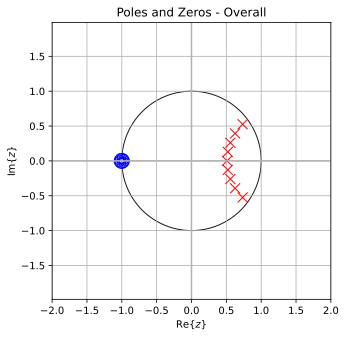

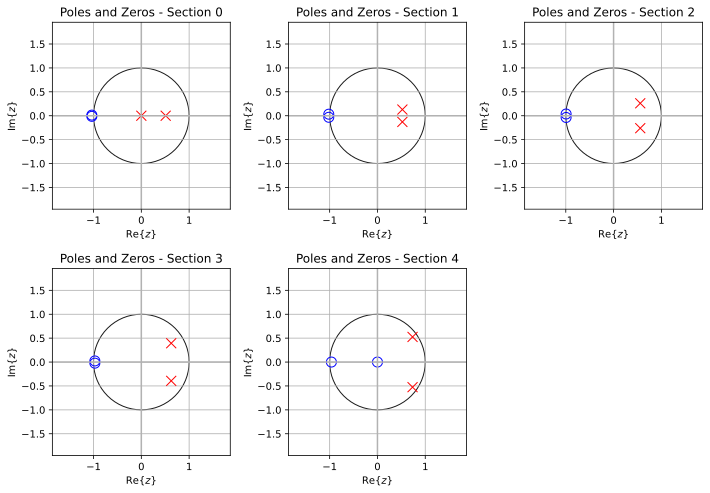

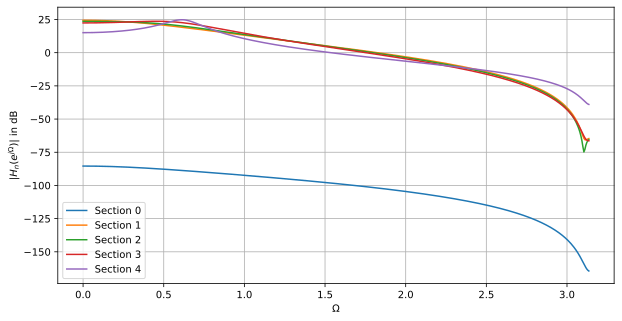

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Circle
import scipy.signal as sig

N = 9  # order of recursive filter


def zplane(z, p, title='Poles and Zeros'):
    "Plots zero and pole locations in the complex z-plane"
    ax = plt.gca()

    ax.plot(np.real(z), np.imag(z), 'bo', fillstyle='none', ms=10)
    ax.plot(np.real(p), np.imag(p), 'rx', fillstyle='none', ms=10)
    unit_circle = Circle((0, 0), radius=1, fill=False,
                         color='black', ls='solid', alpha=0.9)
    ax.add_patch(unit_circle)
    ax.axvline(0, color='0.7')
    ax.axhline(0, color='0.7')

    plt.title(title)
    plt.xlabel(r'Re{$z$}')
    plt.ylabel(r'Im{$z$}')
    plt.axis('equal')
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))
    plt.grid()


# design filter
b, a = sig.butter(N, 0.2)
# decomposition into SOS
sos = sig.tf2sos(b, a, pairing='nearest')


# print filter coefficients
print('Coefficients of the recursive part \n')
print(['%1.2f' % ai for ai in a])
print('\n')
print('Coefficients of the recursive part of the individual SOS \n')
print('Section \t a1 \t\t a2')
for n in range(sos.shape[0]):
    print('%d \t\t %1.5f \t %1.5f' % (n, sos[n, 4], sos[n, 5]))

# plot pole and zero locations
plt.figure(figsize=(5, 5))
zplane(np.roots(b), np.roots(a), 'Poles and Zeros - Overall')

plt.figure(figsize=(10, 7))
for n in range(sos.shape[0]):
    plt.subplot(231+n)
    zplane(np.roots(sos[n, 0:3]), np.roots(sos[n, 3:6]),
           title='Poles and Zeros - Section %d' % n)
plt.tight_layout()

# compute and plot frequency response of sections
plt.figure(figsize=(10, 5))
for n in range(sos.shape[0]):
    Om, H = sig.freqz(sos[n, 0:3], sos[n, 3:6])
    plt.plot(Om, 20*np.log10(np.abs(H)), label=r'Section %d' % n)

plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|H_n(e^{j \Omega})|$ in dB')
plt.legend()
plt.grid()

**Exercise**

* What amplitude range is spanned by the filter coefficients?
* What amplitude range is spanned by the SOS coefficients?
* Change the pole/zero grouping strategy from `pairing='nearest'` to `pairing='keep_odd'`. What changes?
* Increase the order `N` of the filter. What changes?

Solution: Inspecting both the coefficients of the recursive part of the original filter and of the individual SOS reveals that the spanned amplitude range is lower for the latter. The choice of the pole/zero grouping strategy influences the locations of the poles/zeros in the individual SOS, the spanned amplitude range of their coefficients and the transfer functions of the individual sections. The total number of SOS scales with the order of the original filter.

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Sascha Spors, Digital Signal Processing - Lecture notes featuring computational examples*.